## 0. Import and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
TRAIN_DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
train_df = pd.read_csv(TRAIN_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

TEST_DATA_PATH = '/opt/ml/input/data/train_dataset/test_data.csv'
test_df = pd.read_csv(TEST_DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 5.68 s, sys: 644 ms, total: 6.33 s
Wall time: 6.33 s


In [3]:
test_df.info(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260114 entries, 0 to 260113
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   userID            260114 non-null  int16         
 1   assessmentItemID  260114 non-null  object        
 2   testId            260114 non-null  object        
 3   answerCode        260114 non-null  int8          
 4   Timestamp         260114 non-null  datetime64[ns]
 5   KnowledgeTag      260114 non-null  int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 7.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime6

(None, None)

## 1. 기본적인 내용 파악

정리하면,   
`userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
`assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
`testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
`answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
`Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
`KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   
특성 별로 자세히 살펴봅시다.

### 특성의 기본 정보

In [4]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [5]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {train_df.userID.nunique()}
assessmentItemID : {train_df.assessmentItemID.nunique()}
testID           : {train_df.testId.nunique()}
mean answer rate : {train_df.answerCode.sum() / train_df.shape[0] * 100:.2f}%
KnowledgeTag     : {train_df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


## 2. 문제 난이도 파악

In [6]:
def percentile(s):
    return np.sum(s) / len(s)

In [7]:
train_df['big_features'] = train_df['testId'].apply(lambda x : x[2])
test_df['big_features'] = test_df['testId'].apply(lambda x : x[2])

In [8]:
stu_groupby = train_df.groupby('big_features').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})

test_stu_groupby = test_df.groupby('big_features').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})

stu_groupby

,assessmentItemID,answerCode
big_features,,
1,272082,0.800876
2,268327,0.737593
3,273762,0.702238
4,267323,0.684056
5,275773,0.658208
6,264434,0.709232
7,279164,0.521876
8,246336,0.502598
9,119385,0.449948


In [9]:
stu_groupby.index = stu_groupby.index.astype(int)
stu_groupby.reset_index().corr()

,big_features,assessmentItemID,answerCode
big_features,1.000000,-0.603749,-0.929329
assessmentItemID,-0.603749,1.000000,0.636750
answerCode,-0.929329,0.636750,1.000000


- train데이터와 test데이터의 큰 카테고리별 정답률 분포

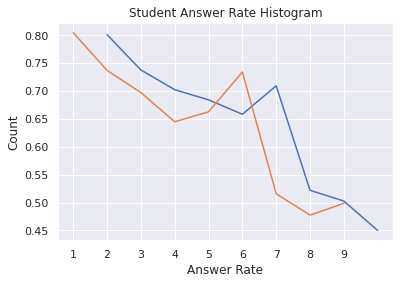

In [10]:
fig, ax = plt.subplots()
ax.plot(stu_groupby.index, stu_groupby['answerCode'])
ax.plot(test_stu_groupby.index, test_stu_groupby['answerCode'])
ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.grid(b=True)

### 2-1. 문제 big feature별로 knowledgeTag 난이도

In [11]:
stu_tag_groupby = train_df.groupby(['big_features', 'KnowledgeTag']).agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})

test_stu_tag_groupby = test_df.groupby(['big_features', 'KnowledgeTag']).agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_tag_groupby

assessmentItemID  answerCode
big_features KnowledgeTag                              
1            5485                      5706    0.849457
             5814                      5635    0.837445
             5834                      4419    0.856076
             5836                      5019    0.804144
             5844                      3767    0.929387
...                                     ...         ...
9            10764                      358    0.550279
             10766                      183    0.355191
             10778                      404    0.455446
             10784                      501    0.508982
             10795                       94    0.468085

[913 rows x 2 columns]

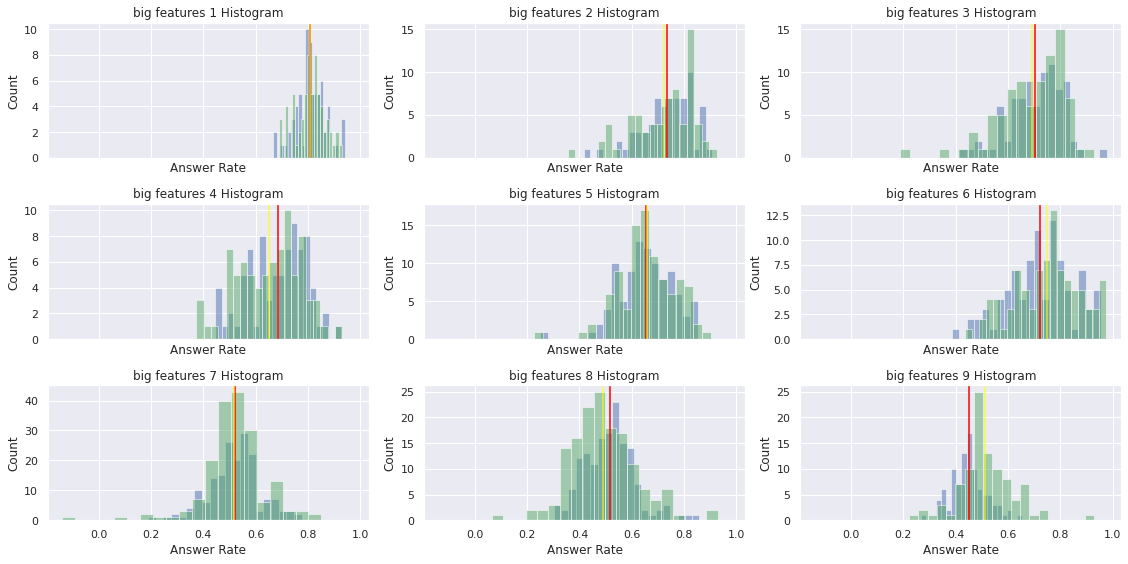

In [12]:
fig, ax = plt.subplots(3, 3, figsize = (16, 8), sharex=True)

for i in range(9):
    ax[i // 3][i % 3].hist(stu_tag_groupby.loc[f'{i + 1}']['answerCode'], bins = 20, alpha = 0.5, color = 'b')
    ax[i // 3][i % 3].hist(test_stu_tag_groupby.loc[f'{i + 1}']['answerCode'], bins = 20, alpha = 0.5, color = 'g')
    ax[i // 3][i % 3].set_title(f'big features {i + 1} Histogram')
    ax[i // 3][i % 3].set_xlabel('Answer Rate')
    ax[i // 3][i % 3].set_ylabel('Count')
    ax[i // 3][i % 3].axvline(stu_tag_groupby.loc[f'{i + 1}']['answerCode'].mean(), color='red')
    ax[i // 3][i % 3].axvline(test_stu_tag_groupby.loc[f'{i + 1}']['answerCode'].mean(), color='yellow', alpha = 0.7)

plt.tight_layout()

### 2-2. 문제 big feature별로 시험지 난이도

In [13]:
stu_test_groupby = train_df.groupby(['big_features', 'testId']).agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_test_groupby

assessmentItemID  answerCode
big_features testId                                  
1            A010000001              1585    0.926183
             A010000002              1550    0.931613
             A010000003              1615    0.846440
             A010000004              1540    0.883117
             A010000005              1595    0.855172
...                                   ...         ...
9            A090000070               344    0.418605
             A090000071               360    0.336111
             A090000072               270    0.418519
             A090000073               270    0.529630
             A090000074               270    0.425926

[1537 rows x 2 columns]

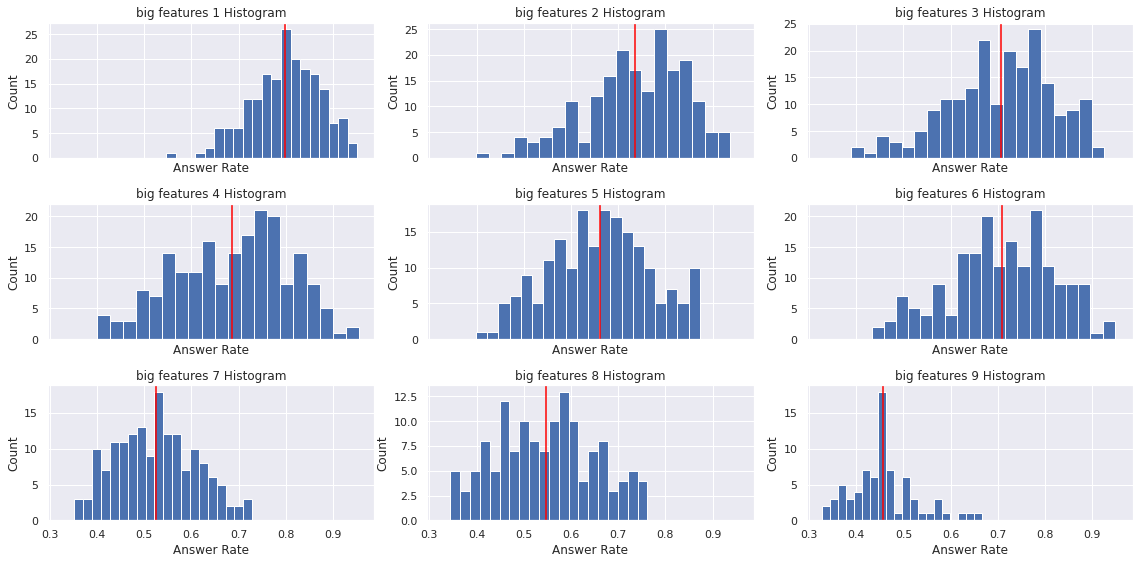

In [14]:
fig, ax = plt.subplots(3, 3, figsize = (16, 8), sharex=True)

for i in range(9):
    ax[i // 3][i % 3].hist(stu_test_groupby.loc[f'{i + 1}']['answerCode'], bins = 20)
    ax[i // 3][i % 3].set_title(f'big features {i + 1} Histogram')
    ax[i // 3][i % 3].set_xlabel('Answer Rate')
    ax[i // 3][i % 3].set_ylabel('Count')
    ax[i // 3][i % 3].axvline(stu_test_groupby.loc[f'{i + 1}']['answerCode'].mean(), color='red')

plt.tight_layout()

### 2-3. 문제 big feature별로 문항 난이도

In [15]:
stu_assessment_groupby = train_df.groupby(['big_features', 'assessmentItemID']).agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_assessment_groupby

assessmentItemID  answerCode
big_features assessmentItemID                              
1            A010001001                     317    0.930599
             A010001002                     317    0.958991
             A010001003                     317    0.905363
             A010001004                     317    0.949527
             A010001005                     317    0.886435
...                                         ...         ...
9            A090074002                      45    0.444444
             A090074003                      45    0.577778
             A090074004                      45    0.333333
             A090074005                      45    0.400000
             A090074006                      45    0.466667

[9454 rows x 2 columns]

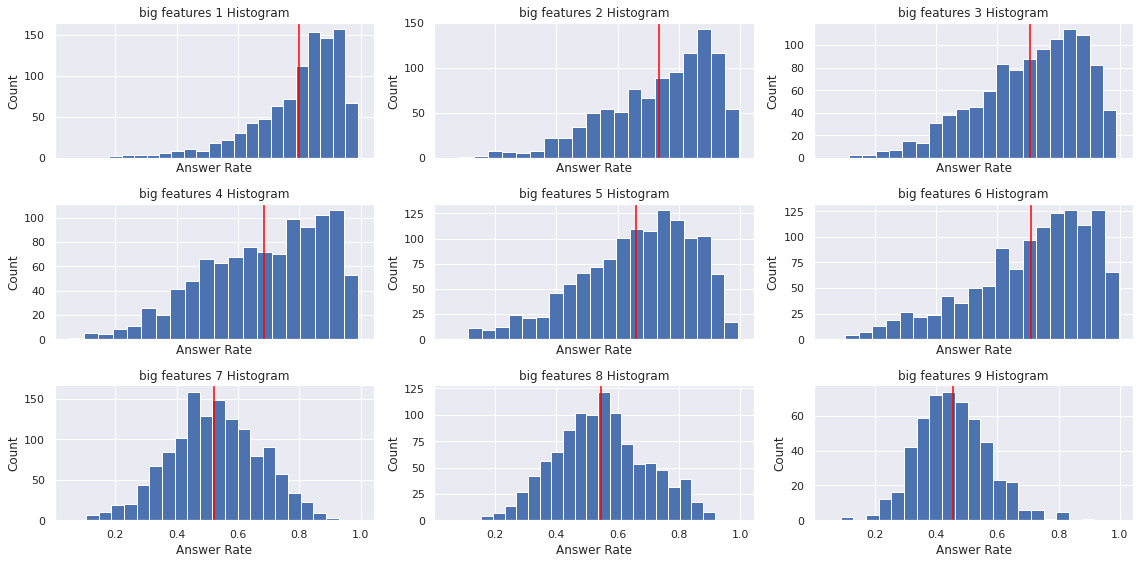

In [16]:
fig, ax = plt.subplots(3, 3, figsize = (16, 8), sharex=True)

for i in range(9):
    ax[i // 3][i % 3].hist(stu_assessment_groupby.loc[f'{i + 1}']['answerCode'], bins = 20)
    ax[i // 3][i % 3].set_title(f'big features {i + 1} Histogram')
    ax[i // 3][i % 3].set_xlabel('Answer Rate')
    ax[i // 3][i % 3].set_ylabel('Count')
    ax[i // 3][i % 3].axvline(stu_assessment_groupby.loc[f'{i + 1}']['answerCode'].mean(), color='red')

plt.tight_layout()

## 3. feature engineering

In [17]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,big_features
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4


In [18]:
def percentile(s):
    return np.sum(s) / len(s)

train_df = train_df.reset_index()
# 큰 카테고리
train_df['big_features'] = train_df['testId'].apply(lambda x : x[2]).astype(int)

# 큰 카테고리별 정답률
stu_groupby = train_df.groupby('big_features').agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'answerCode' : 'answer_rate'})

# tag별 정답률
stu_tag_groupby = train_df.groupby(['big_features', 'KnowledgeTag']).agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'answerCode' : 'answer_rate'})

# 시험지별 정답률
stu_test_groupby = train_df.groupby(['big_features', 'testId']).agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'answerCode' : 'answer_rate'})

# 문항별 정답률
stu_assessment_groupby = train_df.groupby(['big_features', 'assessmentItemID']).agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'assessmentItemID' : 'assessment_count', 'answerCode' : 'answer_rate'})

train_df = train_df.sort_values(by='index', axis=0)

# 정답 - 큰 카테고리별 정답률 
'''ex)
맞은 문제의 큰 카테고리별 정답률이 0.7 이면 1 - 0.7 = 0.3이 됨)
틀린 문제의 큰 카테고리별 정답률이 0.7 이면 0 - 0.7 = -0.7이 됨)
'''
temp = pd.merge(train_df, stu_groupby.reset_index()[['big_features', 'answer_rate']], on = ['big_features'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
train_df['big_mean'] = temp['answer_rate']
train_df['answer_delta'] = temp['answerCode'] - temp['answer_rate']

# 정답 - 태그별 정답률
temp = pd.merge(train_df, stu_tag_groupby.reset_index()[['answer_rate', 'big_features', 'KnowledgeTag']], on = ['big_features', 'KnowledgeTag'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
train_df['tag_mean'] = temp['answer_rate']
train_df['tag_delta'] = temp['answerCode'] - temp['answer_rate']

# 정답 - 시험별 정답률
temp = pd.merge(train_df, stu_test_groupby.reset_index()[['answer_rate', 'big_features', 'testId']], on = ['big_features', 'testId'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
train_df['test_mean'] = temp['answer_rate']
train_df['test_delta'] = temp['answerCode'] - temp['answer_rate']

# 정답 - 문항별 정답률
temp = pd.merge(train_df, stu_assessment_groupby.reset_index()[['answer_rate', 'big_features', 'assessmentItemID']], on = ['big_features', 'assessmentItemID'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
train_df['assess_mean'] = temp['answer_rate']
train_df['assess_delta'] = temp['answerCode'] - temp['answer_rate']

## train set, test set feature 분포

In [19]:
def percentile(s):
    return np.sum(s) / len(s)

test_df = test_df.reset_index()
# 큰 카테고리
test_df['big_features'] = test_df['testId'].apply(lambda x : x[2]).astype(int)

# 큰 카테고리별 정답률
stu_groupby = test_df.groupby('big_features').agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'answerCode' : 'answer_rate'})

# tag별 정답률
stu_tag_groupby = test_df.groupby(['big_features', 'KnowledgeTag']).agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'answerCode' : 'answer_rate'})

# 시험지별 정답률
stu_test_groupby = test_df.groupby(['big_features', 'testId']).agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'answerCode' : 'answer_rate'})

# 문항별 정답률
stu_assessment_groupby = test_df.groupby(['big_features', 'assessmentItemID']).agg({
'assessmentItemID': 'count',
'answerCode': percentile
}).rename(columns = {'assessmentItemID' : 'assessment_count', 'answerCode' : 'answer_rate'})

test_df = test_df.sort_values(by='index', axis=0)

# 정답 - 큰 카테고리별 정답률 
'''ex)
맞은 문제의 큰 카테고리별 정답률이 0.7 이면 1 - 0.7 = 0.3이 됨)
틀린 문제의 큰 카테고리별 정답률이 0.7 이면 0 - 0.7 = -0.7이 됨)
'''
temp = pd.merge(test_df, stu_groupby.reset_index()[['big_features', 'answer_rate']], on = ['big_features'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
test_df['big_mean'] = temp['answer_rate']
test_df['answer_delta'] = temp['answerCode'] - temp['answer_rate']

# 정답 - 태그별 정답률
temp = pd.merge(test_df, stu_tag_groupby.reset_index()[['answer_rate', 'big_features', 'KnowledgeTag']], on = ['big_features', 'KnowledgeTag'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
test_df['tag_mean'] = temp['answer_rate']
test_df['tag_delta'] = temp['answerCode'] - temp['answer_rate']

# 정답 - 시험별 정답률
temp = pd.merge(test_df, stu_test_groupby.reset_index()[['answer_rate', 'big_features', 'testId']], on = ['big_features', 'testId'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
test_df['test_mean'] = temp['answer_rate']
test_df['test_delta'] = temp['answerCode'] - temp['answer_rate']

# 정답 - 문항별 정답률
temp = pd.merge(test_df, stu_assessment_groupby.reset_index()[['answer_rate', 'big_features', 'assessmentItemID']], on = ['big_features', 'assessmentItemID'])
temp = temp.sort_values(by='index', axis=0).set_index('index')
test_df['assess_mean'] = temp['answer_rate']
test_df['assess_delta'] = temp['answerCode'] - temp['answer_rate']

### big_feature

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


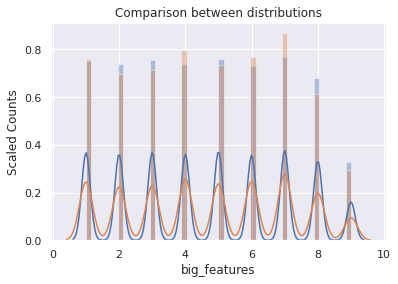

In [20]:
fig, ax = plt.subplots()
ax.set_title('Comparison between distributions')
ax.set_xlabel('Answer Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['big_features'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['big_features'], hist=True, kde=True, ax = ax)
plt.show()

### answer_delta

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


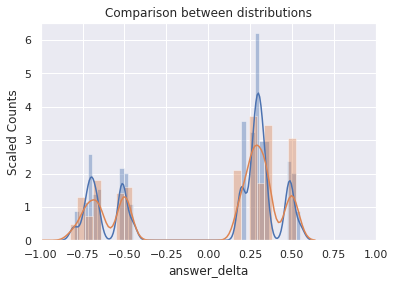

In [21]:
fig, ax = plt.subplots()
ax.set_title('Comparison between distributions')
ax.set_xlim(-1, 1)
ax.set_xlabel('Answer Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['answer_delta'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['answer_delta'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


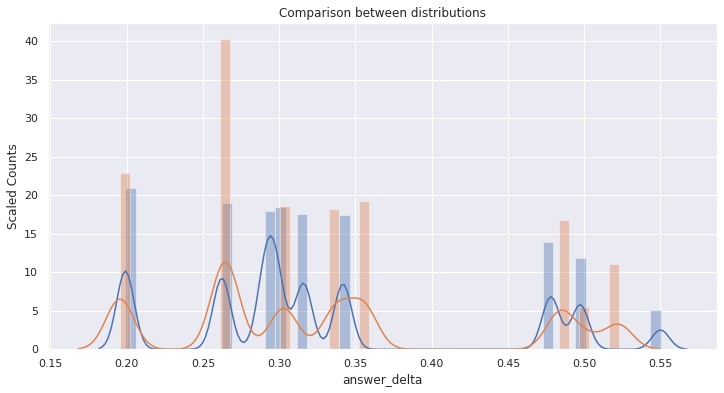

In [22]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Answer Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['answer_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['answer_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


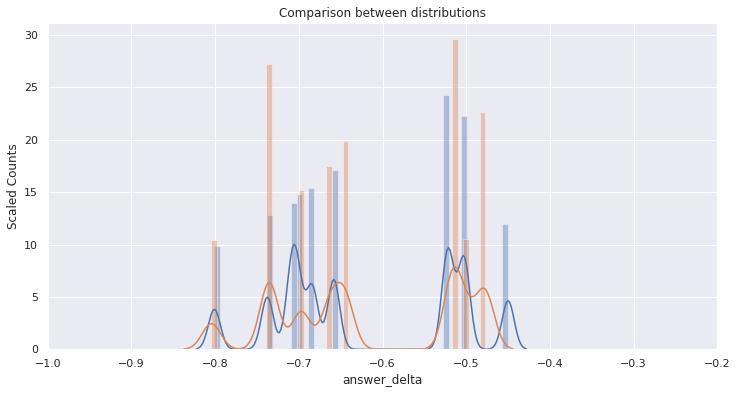

In [23]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
ax.set_xlim(-1, -0.2)
ax.set_xlabel('Answer Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['answer_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['answer_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

### tag_delta

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


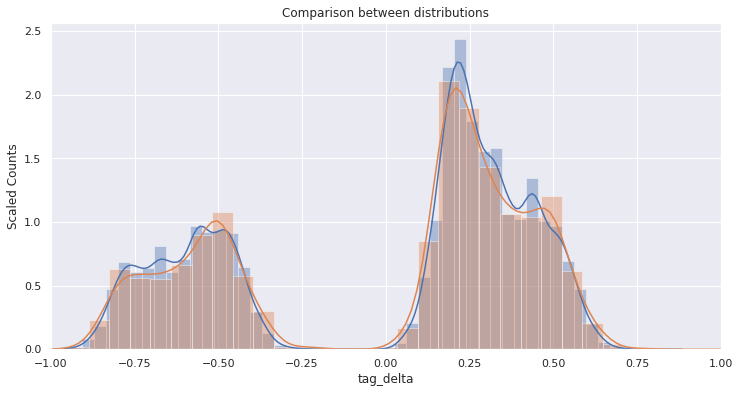

In [24]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlim(-1, 1)
ax.set_title('Comparison between distributions')
ax.set_xlabel('Tag Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['tag_delta'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['tag_delta'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


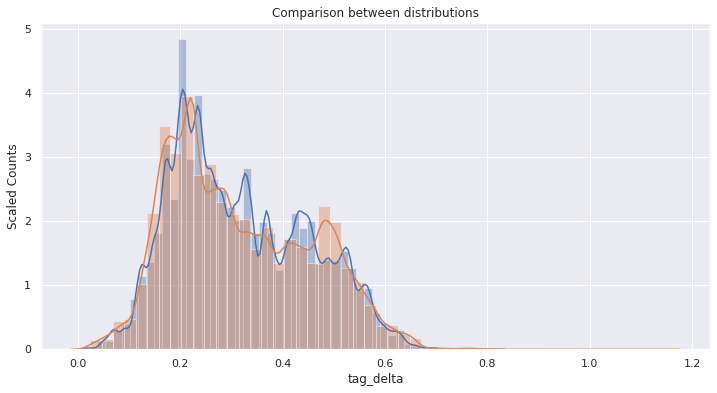

In [25]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Answer Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['tag_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['tag_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


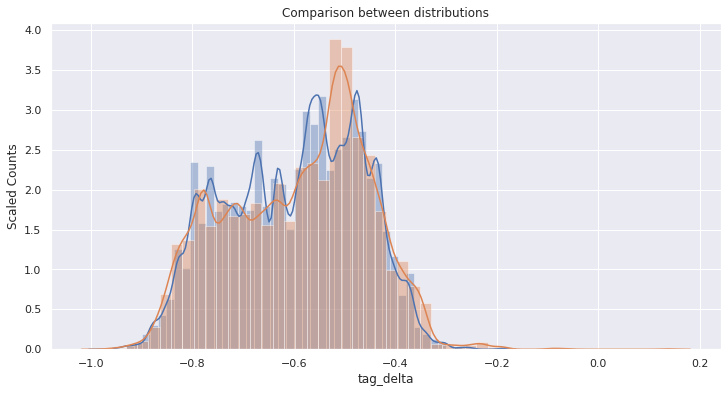

In [26]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Answer Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['tag_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['tag_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

### test_delta

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


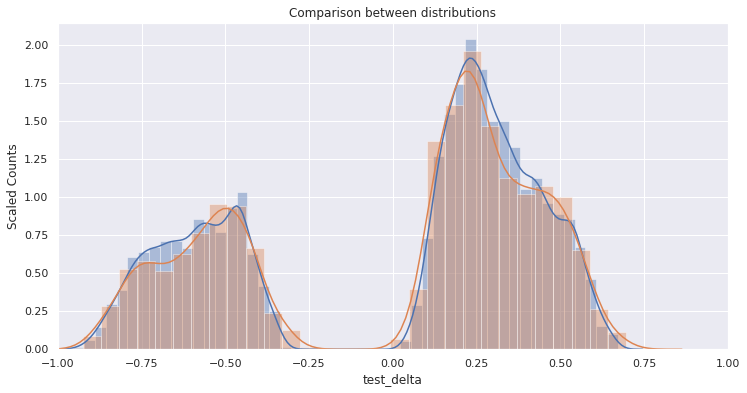

In [27]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlim(-1, 1)
ax.set_title('Comparison between distributions')
ax.set_xlabel('Test Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['test_delta'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['test_delta'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


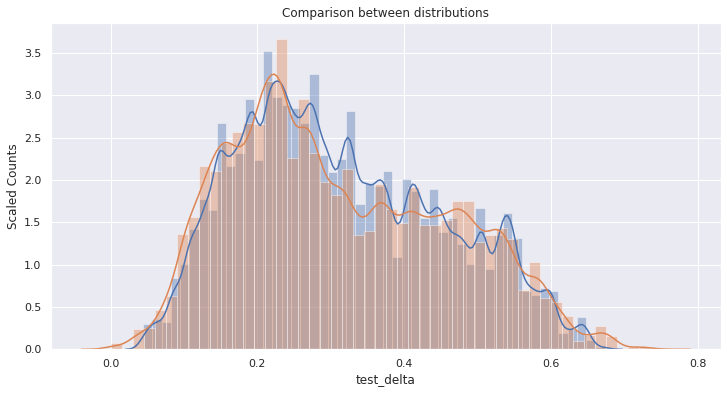

In [28]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Test Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['test_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['test_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


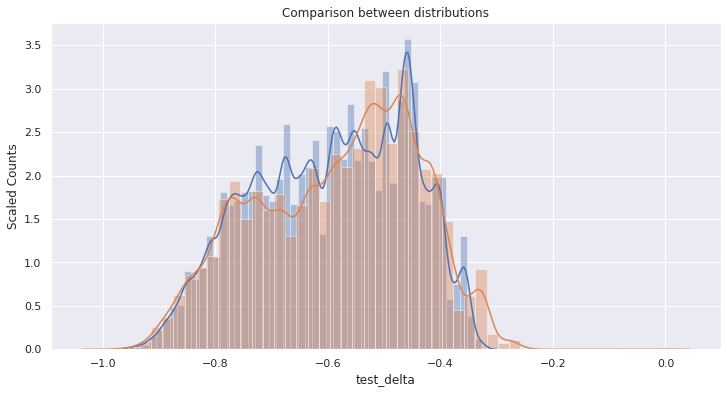

In [29]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Test Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['test_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['test_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

### assess delta

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


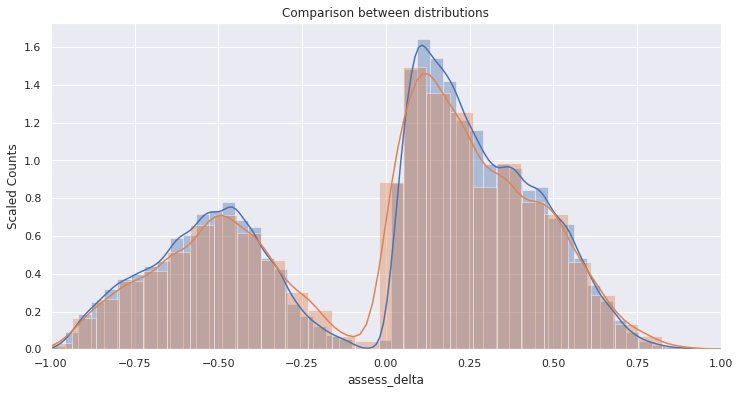

In [30]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlim(-1, 1)
ax.set_title('Comparison between distributions')
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['assess_delta'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['assess_delta'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


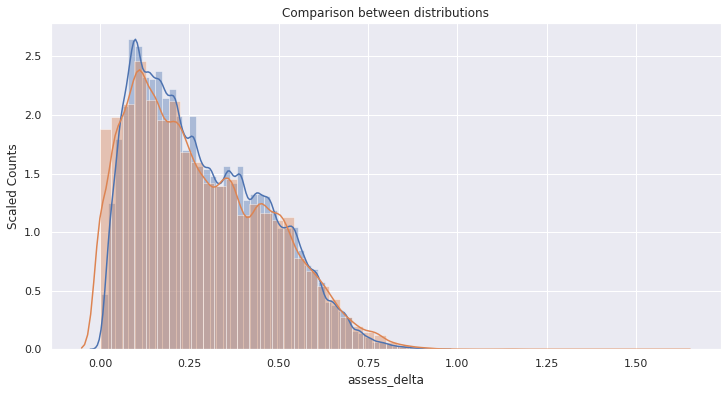

In [31]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['assess_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['assess_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


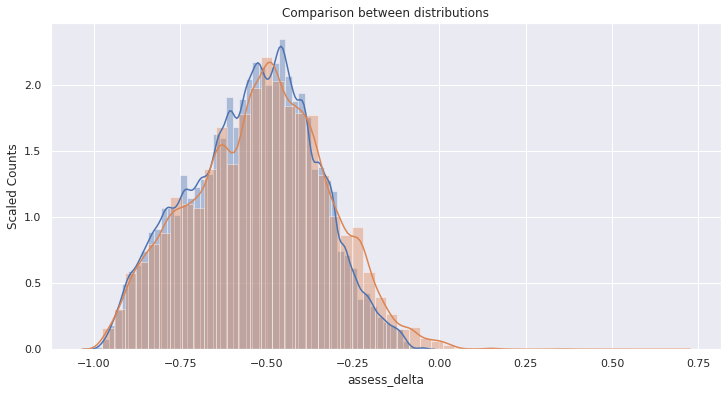

In [32]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['assess_delta'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['assess_delta'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

### big mean

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


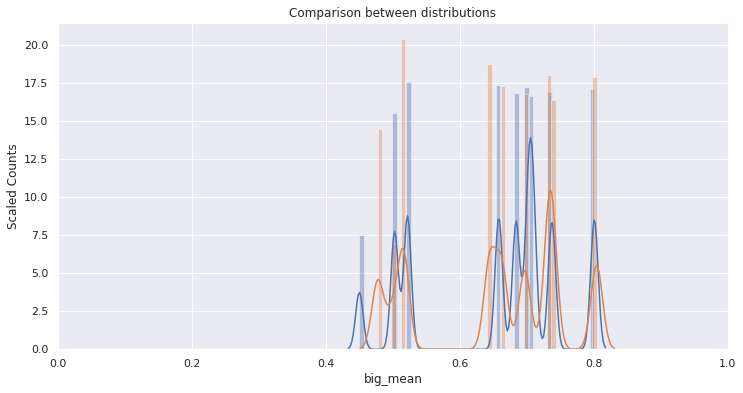

In [33]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlim(0, 1)
ax.set_title('Comparison between distributions')
ax.set_xlabel('Big Mean')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['big_mean'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['big_mean'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


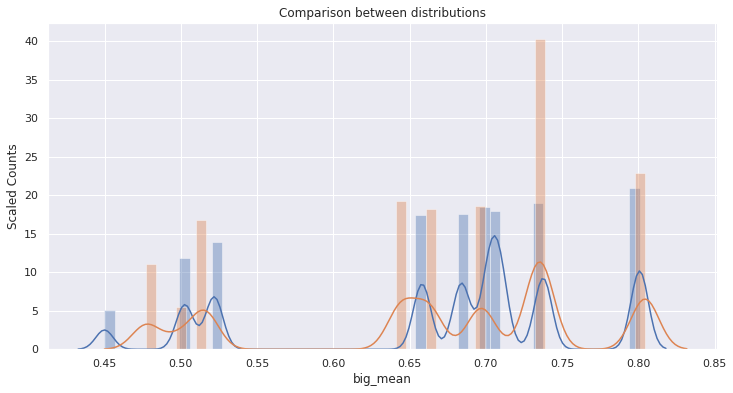

In [34]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['big_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['big_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


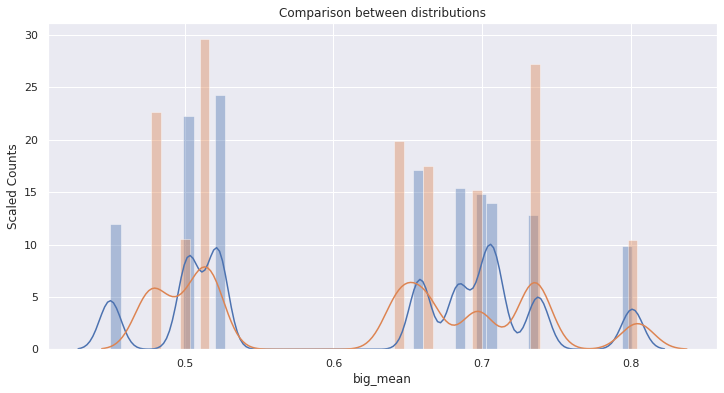

In [35]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['big_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['big_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

### tag mean

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


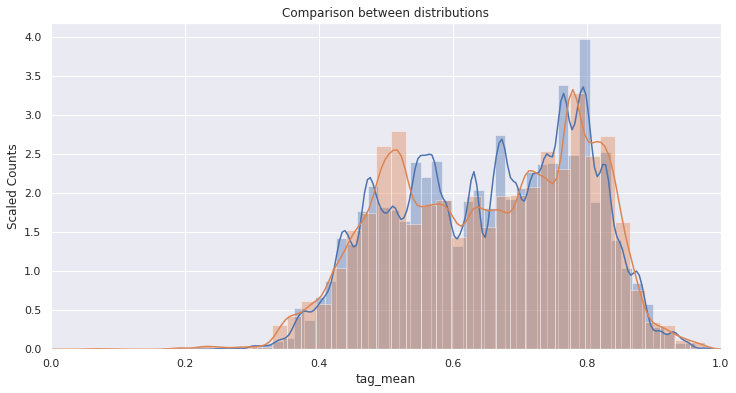

In [36]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlim(0, 1)
ax.set_title('Comparison between distributions')
ax.set_xlabel('Tag Mean')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['tag_mean'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['tag_mean'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


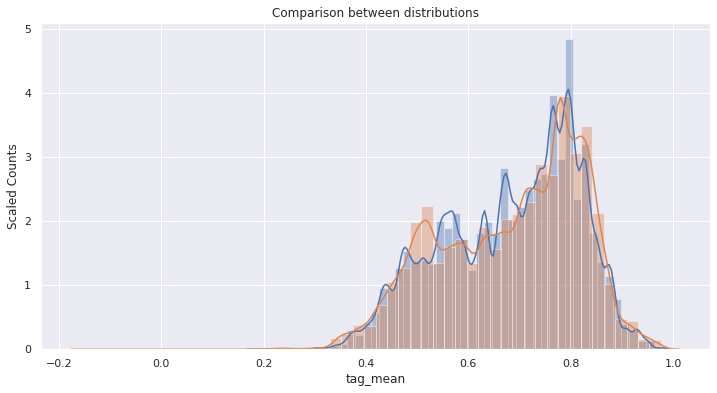

In [37]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['tag_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['tag_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


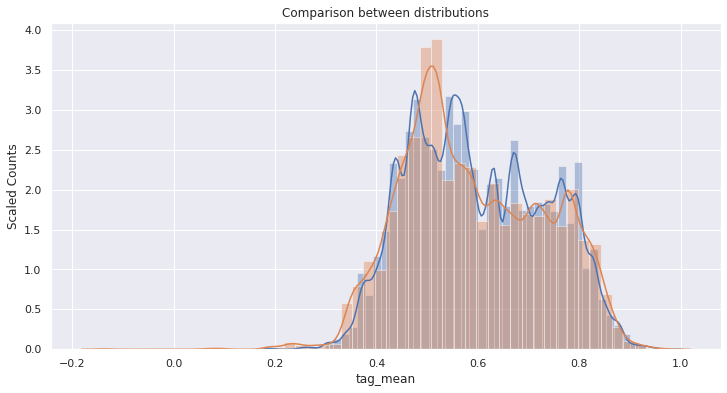

In [38]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['tag_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['tag_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

### test mean

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


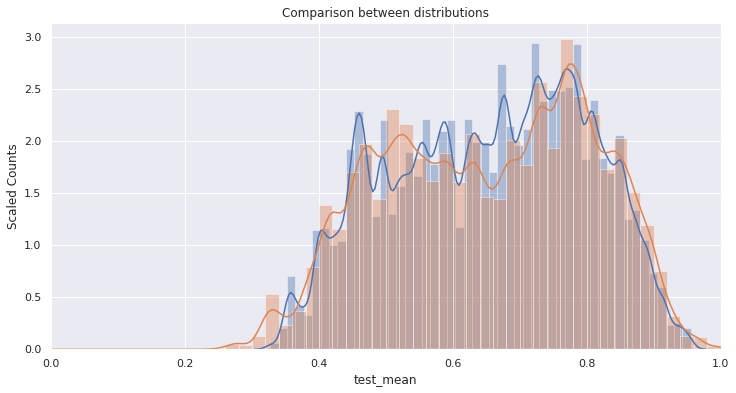

In [39]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlim(0, 1)
ax.set_title('Comparison between distributions')
ax.set_xlabel('Test Mean')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['test_mean'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['test_mean'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


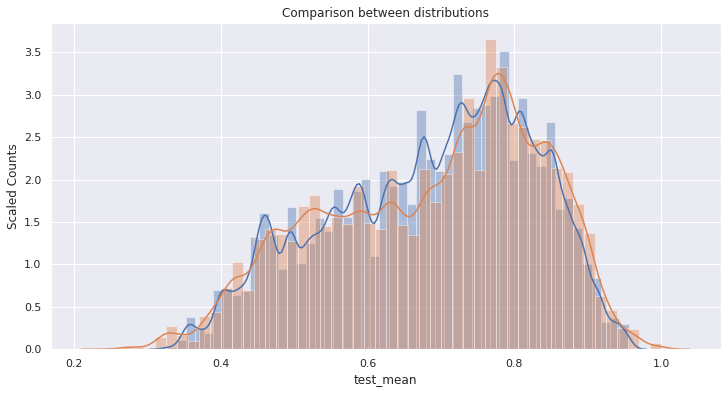

In [40]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['test_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['test_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


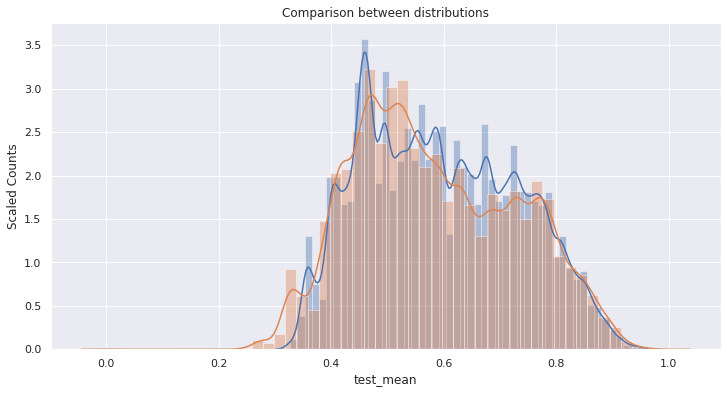

In [41]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['test_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['test_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

### assess mean

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


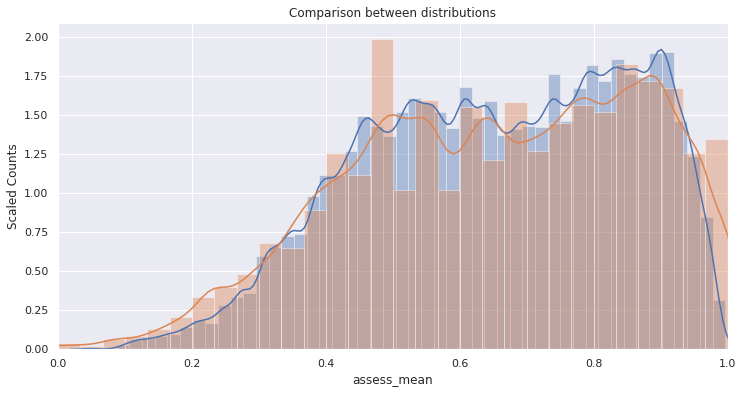

In [42]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlim(0, 1)
ax.set_title('Comparison between distributions')
ax.set_xlabel('Assess Mean')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df['assess_mean'], hist=True, kde=True, ax = ax)
sns.distplot(test_df['assess_mean'], hist=True, kde=True, ax = ax)
plt.show()

- 맞은 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


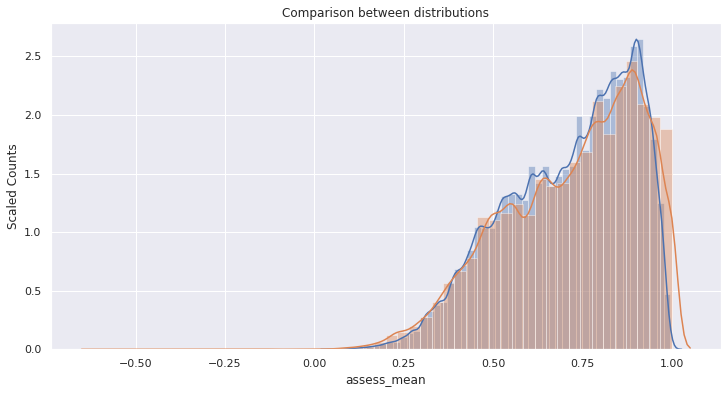

In [43]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 1]['assess_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 1]['assess_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()

- 틀린 문제

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


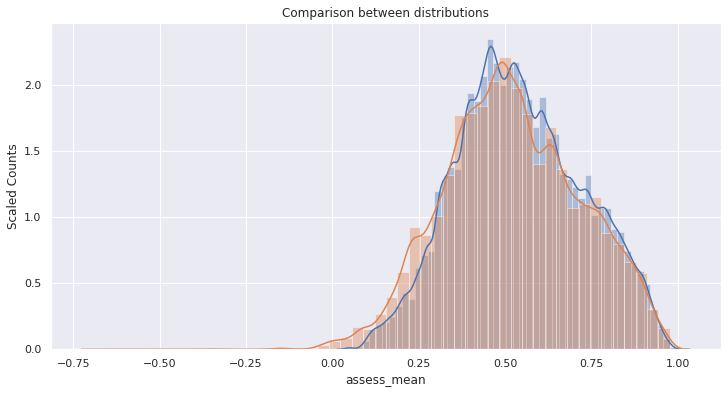

In [44]:
fig, ax = plt.subplots(figsize = (12,6))
ax.set_title('Comparison between distributions')
# ax.set_xlim(-1, 1)
ax.set_xlabel('Assess Delta')
ax.set_ylabel('Scaled Counts')
sns.distplot(train_df[train_df['answerCode'] == 0]['assess_mean'], bins = 50, hist=True, kde=True, ax = ax)
sns.distplot(test_df[test_df['answerCode'] == 0]['assess_mean'], bins = 50, hist=True, kde=True, ax = ax)
plt.show()